In [ ]:
## model - resnet18 

C:\Users\dubey\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\dubey\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Loss: 0.37923082944593933, Val Loss: 0.4382824134081602, Accuracy: 0.8585858585858586, Val Accuracy: 0.8784313725490196
Epoch 2/20, Loss: 0.21755255498972378, Val Loss: 0.21577181667089462, Accuracy: 0.9191919191919192, Val Accuracy: 0.9098039215686274
Epoch 3/20, Loss: 0.19006968544502006, Val Loss: 1.7636585384607315, Accuracy: 0.9351851851851852, Val Accuracy: 0.5019607843137255
Epoch 4/20, Loss: 0.2682114745441236, Val Loss: 0.32070083916187286, Accuracy: 0.8888888888888888, Val Accuracy: 0.8588235294117647
Epoch 5/20, Loss: 0.1604828491414848, Val Loss: 0.25451769959181547, Accuracy: 0.9436026936026936, Val Accuracy: 0.9215686274509803
Epoch 6/20, Loss: 0.1743893959608517, Val Loss: 0.20071373507380486, Accuracy: 0.9343434343434344, Val Accuracy: 0.9137254901960784
Epoch 7/20, Loss: 0.20376350358128548, Val Loss: 0.17781272809952497, Accuracy: 0.9419191919191919, Val Accuracy: 0.9137254901960784
Epoch 8/20, Loss: 0.17769213285493224, Val Loss: 0.24006850109435618, Accu

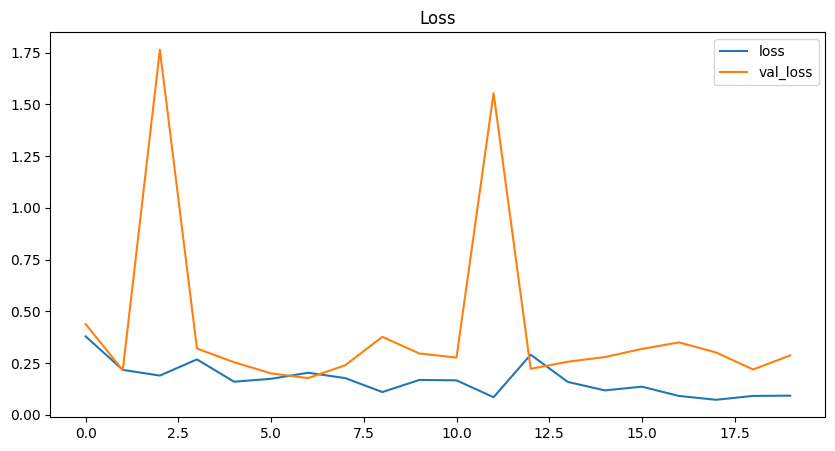

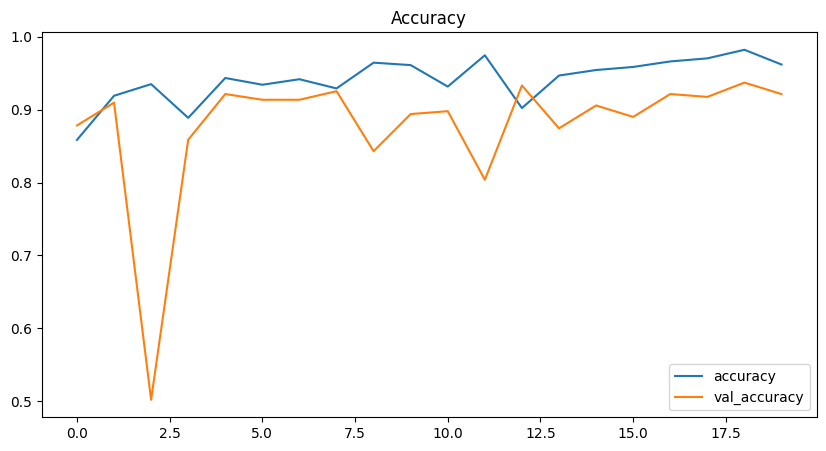

Precision: 0.9389312863349915
Recall: 0.984000027179718
Accuracy: 0.9607843160629272


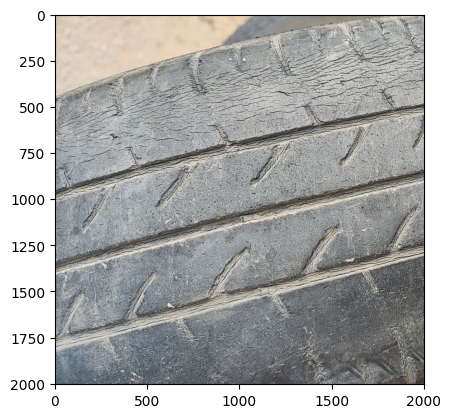

Predicted class is defective tyre


In [1]:
import os
import cv2
import imghdr
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import torchmetrics

# GPU setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing
#data_dir = r"C:\Users\dubey\OneDrive\Desktop\Dait (Summer Intership )\Tyre dataset"
data_dir = r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\Tyre dataset"

image_exts = ['jpeg', 'jpg', 'bmp', 'png']

# Validate and clean data
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# Custom Dataset
class TyreDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = os.listdir(data_dir)
        self.image_paths = []
        self.labels = []

        for idx, image_class in enumerate(self.classes):
            image_class_path = os.path.join(data_dir, image_class)
            for image in os.listdir(image_class_path):
                image_path = os.path.join(image_class_path, image)
                self.image_paths.append(image_path)
                self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create dataset
dataset = TyreDataset(data_dir, transform=transform)

# Split dataset
train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=0.3, stratify=dataset.labels)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, stratify=[dataset.labels[i] for i in test_idx])

train_data = Subset(dataset, train_idx)
val_data = Subset(dataset, val_idx)
test_data = Subset(dataset, test_idx)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

# Model definition
class TyreClassifier(nn.Module):
    def __init__(self):
        super(TyreClassifier, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = TyreClassifier().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float()

            optimizer.zero_grad()
            outputs = model(images).squeeze()

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = outputs.round()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        val_loss = 0
        val_correct = 0
        val_total = 0
        model.eval()
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float()

                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                preds = outputs.round()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        history['loss'].append(train_loss/len(train_loader))
        history['val_loss'].append(val_loss/len(val_loader))
        history['accuracy'].append(correct/total)
        history['val_accuracy'].append(val_correct/val_total)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}, Accuracy: {correct/total}, Val Accuracy: {val_correct/val_total}')

    return history

# Train the model
history = train_model(model, train_loader, val_loader, criterion, optimizer)

# Plotting the results
plt.figure(figsize=(10,5))
plt.title("Loss")
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Accuracy")
plt.plot(history['accuracy'], label='accuracy')
plt.plot(history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

# Evaluation
model.eval()
#precision = torchmetrics.Precision().to(device)
#recall = torchmetrics.Recall().to(device)
#accuracy = torchmetrics.Accuracy().to(device)
precision = torchmetrics.classification.Precision(task="binary").to(device)
recall = torchmetrics.classification.Recall(task="binary").to(device)
accuracy = torchmetrics.classification.Accuracy(task="binary").to(device)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float()
        outputs = model(images).squeeze()

        preds = outputs.round()
        #precision = torchmetrics.Precision(task="binary").to(device)
        #recall = torchmetrics.Recall(task="binary").to(device)
        #accuracy = torchmetrics.Accuracy(task="binary").to(device)

        precision.update(preds, labels)
        recall.update(preds, labels)
        accuracy.update(preds, labels)

print(f'Precision: {precision.compute()}')
print(f'Recall: {recall.compute()}')
print(f'Accuracy: {accuracy.compute()}')

# Prediction example
def predict_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        yhat = model(img).squeeze().item()

    if yhat > 0.5:
        print(f'Predicted class is good tyre')
    else:
        print(f'Predicted class is defective tyre')
#test_image_path = r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\trainging image for tyre\Defective (1).jpg"

#predict_image(r"C:\Users\dubey\OneDrive\Desktop\Dait (Summer Intership )\Good\good (1).jpg")
predict_image(r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\trainging image for tyre\Defective (1).jpg")

In [5]:
import torch

# Save the model's state_dict (recommended for PyTorch models)
torch.save(model.state_dict(), 'tyre_model.pth')
print("Model saved successfully.")

Model saved successfully.


In [6]:
# Load model structure first
model = TyreClassifier()
model.load_state_dict(torch.load('tyre_model.pth'))
model.eval()
print("Model loaded successfully.")

Model loaded successfully.


In [ ]:
## EfficientNet-based 

C:\Users\dubey\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\dubey\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\dubey/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████████████████████████████████████████████████████████████████████████| 20.5M/20.5M [01:40<00:00, 213kB/s]


Epoch 1/20, Loss: 0.23489502366436155, Val Loss: 0.17869974649511278, Accuracy: 0.9158249158249159, Val Accuracy: 0.9568627450980393
Epoch 2/20, Loss: 0.15586626061581468, Val Loss: 0.14212512294761837, Accuracy: 0.9663299663299664, Val Accuracy: 0.9568627450980393
Epoch 3/20, Loss: 0.11801504821663625, Val Loss: 0.14182729250751436, Accuracy: 0.9553872053872053, Val Accuracy: 0.9568627450980393
Epoch 4/20, Loss: 0.043788521035917495, Val Loss: 0.09063191141467541, Accuracy: 0.9856902356902357, Val Accuracy: 0.9725490196078431
Epoch 5/20, Loss: 0.04694145448248539, Val Loss: 0.06215006043203175, Accuracy: 0.984006734006734, Val Accuracy: 0.9882352941176471
Epoch 6/20, Loss: 0.0892809183569625, Val Loss: 0.11682673773611896, Accuracy: 0.9713804713804713, Val Accuracy: 0.9529411764705882
Epoch 7/20, Loss: 0.0799252382528625, Val Loss: 0.04458218766376376, Accuracy: 0.9747474747474747, Val Accuracy: 0.9803921568627451
Epoch 8/20, Loss: 0.02775044169002764, Val Loss: 0.03337738180562155, A

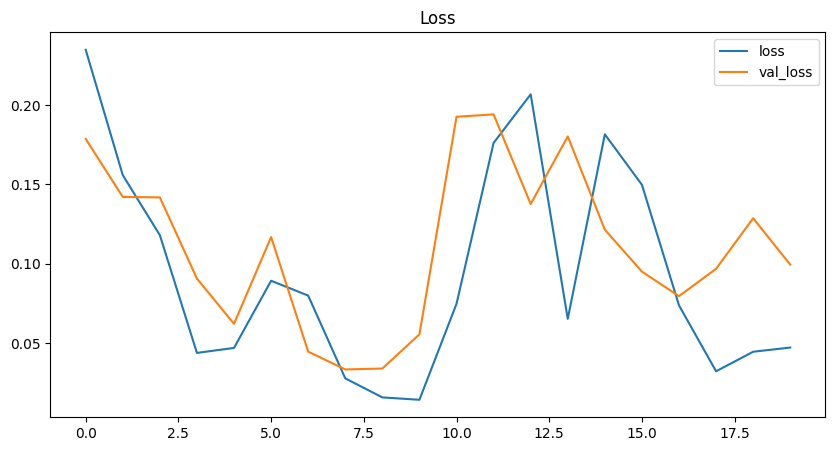

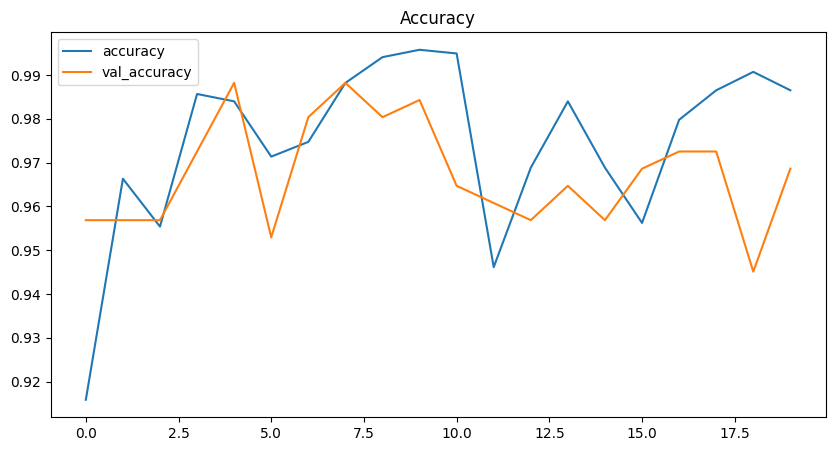

Precision: 0.9677419066429138
Recall: 0.9599999785423279
Accuracy: 0.9647058844566345


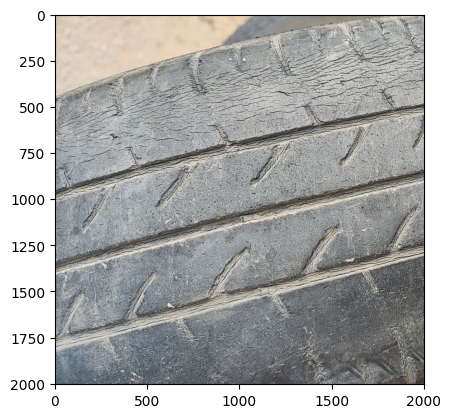

Predicted class is defective tyre


In [13]:
import os
import cv2
import imghdr
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import torchmetrics

# GPU setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing
#data_dir = r"C:\Users\dubey\OneDrive\Desktop\Dait (Summer Intership )\Tyre dataset"
data_dir = r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\Tyre dataset"

image_exts = ['jpeg', 'jpg', 'bmp', 'png']

# Validate and clean data
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# Custom Dataset
class TyreDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = os.listdir(data_dir)
        self.image_paths = []
        self.labels = []

        for idx, image_class in enumerate(self.classes):
            image_class_path = os.path.join(data_dir, image_class)
            for image in os.listdir(image_class_path):
                image_path = os.path.join(image_class_path, image)
                self.image_paths.append(image_path)
                self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create dataset
dataset = TyreDataset(data_dir, transform=transform)

# Split dataset
train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=0.3, stratify=dataset.labels)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, stratify=[dataset.labels[i] for i in test_idx])

train_data = Subset(dataset, train_idx)
val_data = Subset(dataset, val_idx)
test_data = Subset(dataset, test_idx)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

# Define EfficientNet-based classifier
class TyreClassifierEfficientNet(nn.Module):
    def __init__(self):
        super(TyreClassifierEfficientNet, self).__init__()
        self.model = models.efficientnet_b0(pretrained=True)
        
        # Replace classifier head
        in_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Instantiate and prepare
model = TyreClassifierEfficientNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float()

            optimizer.zero_grad()
            outputs = model(images).squeeze()

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = outputs.round()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        val_loss = 0
        val_correct = 0
        val_total = 0
        model.eval()
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float()

                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                preds = outputs.round()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        history['loss'].append(train_loss/len(train_loader))
        history['val_loss'].append(val_loss/len(val_loader))
        history['accuracy'].append(correct/total)
        history['val_accuracy'].append(val_correct/val_total)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}, Accuracy: {correct/total}, Val Accuracy: {val_correct/val_total}')

    return history

# Train the model
history = train_model(model, train_loader, val_loader, criterion, optimizer)

# Plotting the results
plt.figure(figsize=(10,5))
plt.title("Loss")
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Accuracy")
plt.plot(history['accuracy'], label='accuracy')
plt.plot(history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

# Evaluation
model.eval()
#precision = torchmetrics.Precision().to(device)
#recall = torchmetrics.Recall().to(device)
#accuracy = torchmetrics.Accuracy().to(device)
precision = torchmetrics.classification.Precision(task="binary").to(device)
recall = torchmetrics.classification.Recall(task="binary").to(device)
accuracy = torchmetrics.classification.Accuracy(task="binary").to(device)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float()
        outputs = model(images).squeeze()

        preds = outputs.round()
        #precision = torchmetrics.Precision(task="binary").to(device)
        #recall = torchmetrics.Recall(task="binary").to(device)
        #accuracy = torchmetrics.Accuracy(task="binary").to(device)

        precision.update(preds, labels)
        recall.update(preds, labels)
        accuracy.update(preds, labels)

print(f'Precision: {precision.compute()}')
print(f'Recall: {recall.compute()}')
print(f'Accuracy: {accuracy.compute()}')

# Prediction example
def predict_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        yhat = model(img).squeeze().item()

    if yhat > 0.5:
        print(f'Predicted class is good tyre')
    else:
        print(f'Predicted class is defective tyre')
#test_image_path = r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\trainging image for tyre\Defective (1).jpg"

#predict_image(r"C:\Users\dubey\OneDrive\Desktop\Dait (Summer Intership )\Good\good (1).jpg")
predict_image(r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\trainging image for tyre\Defective (1).jpg")

In [ ]:
## DenseNet-based classifier

C:\Users\dubey\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\dubey\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\dubey/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|██████████████████████████████████████████████████████████████████████████████| 30.8M/30.8M [02:58<00:00, 182kB/s]


Epoch 1/20, Loss: 0.293922519017207, Val Loss: 0.2636896427720785, Accuracy: 0.8627946127946128, Val Accuracy: 0.9019607843137255
Epoch 2/20, Loss: 0.2381351939157436, Val Loss: 1.3090895414352417, Accuracy: 0.9031986531986532, Val Accuracy: 0.792156862745098
Epoch 3/20, Loss: 0.240492689570314, Val Loss: 0.18871287861838937, Accuracy: 0.9284511784511784, Val Accuracy: 0.9372549019607843
Epoch 4/20, Loss: 0.21976007756433988, Val Loss: 0.2150384383276105, Accuracy: 0.9208754208754208, Val Accuracy: 0.9372549019607843
Epoch 5/20, Loss: 0.16847228087288768, Val Loss: 0.24844194203615189, Accuracy: 0.930976430976431, Val Accuracy: 0.9019607843137255
Epoch 6/20, Loss: 0.17235510850227193, Val Loss: 0.242293955758214, Accuracy: 0.9377104377104377, Val Accuracy: 0.9411764705882353
Epoch 7/20, Loss: 0.10249197823730738, Val Loss: 0.8183817937970161, Accuracy: 0.9646464646464646, Val Accuracy: 0.7568627450980392
Epoch 8/20, Loss: 0.1256302730425408, Val Loss: 0.1750858472660184, Accuracy: 0.96

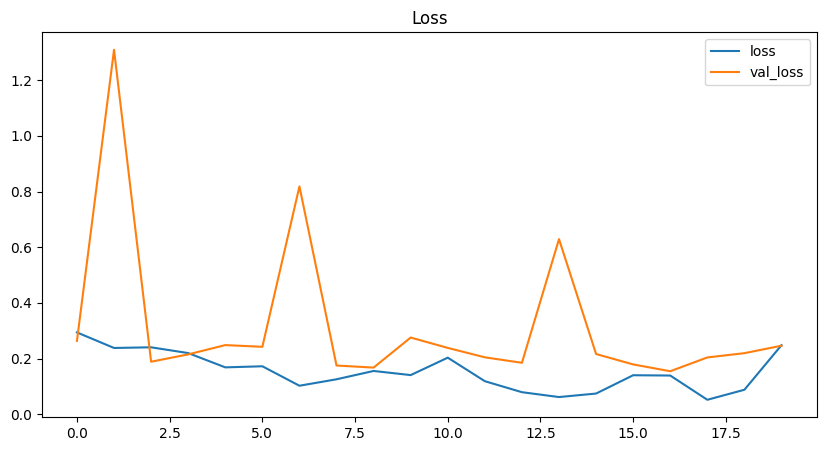

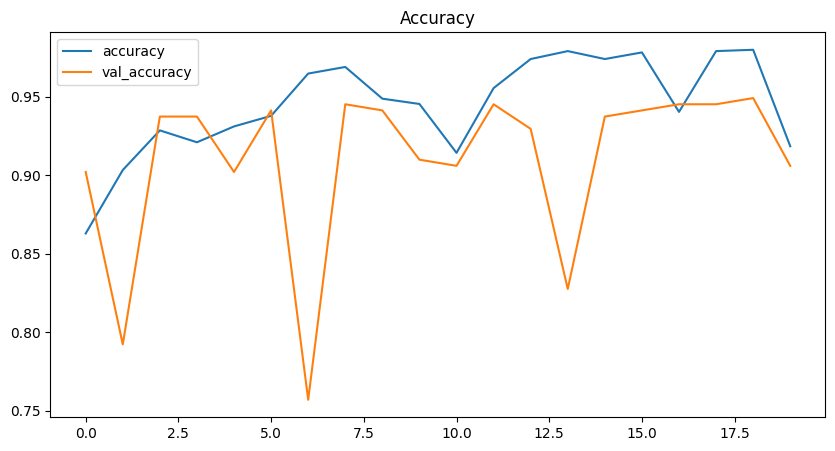

Precision: 0.8769230842590332
Recall: 0.9120000004768372
Accuracy: 0.8941176533699036


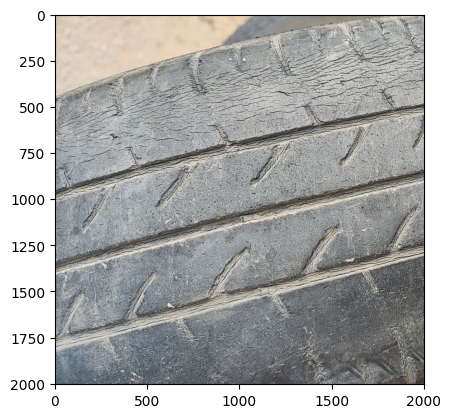

Predicted class is defective tyre


In [14]:
import os
import cv2
import imghdr
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import torchmetrics

# GPU setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing
#data_dir = r"C:\Users\dubey\OneDrive\Desktop\Dait (Summer Intership )\Tyre dataset"
data_dir = r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\Tyre dataset"

image_exts = ['jpeg', 'jpg', 'bmp', 'png']

# Validate and clean data
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# Custom Dataset
class TyreDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = os.listdir(data_dir)
        self.image_paths = []
        self.labels = []

        for idx, image_class in enumerate(self.classes):
            image_class_path = os.path.join(data_dir, image_class)
            for image in os.listdir(image_class_path):
                image_path = os.path.join(image_class_path, image)
                self.image_paths.append(image_path)
                self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create dataset
dataset = TyreDataset(data_dir, transform=transform)

# Split dataset
train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=0.3, stratify=dataset.labels)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, stratify=[dataset.labels[i] for i in test_idx])

train_data = Subset(dataset, train_idx)
val_data = Subset(dataset, val_idx)
test_data = Subset(dataset, test_idx)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

# Define DenseNet-based classifier
class TyreClassifierDenseNet(nn.Module):
    def __init__(self):
        super(TyreClassifierDenseNet, self).__init__()
        self.model = models.densenet121(pretrained=True)
        
        # Replace the classifier head
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Instantiate and prepare
model = TyreClassifierDenseNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float()

            optimizer.zero_grad()
            outputs = model(images).squeeze()

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = outputs.round()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        val_loss = 0
        val_correct = 0
        val_total = 0
        model.eval()
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float()

                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                preds = outputs.round()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        history['loss'].append(train_loss/len(train_loader))
        history['val_loss'].append(val_loss/len(val_loader))
        history['accuracy'].append(correct/total)
        history['val_accuracy'].append(val_correct/val_total)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}, Accuracy: {correct/total}, Val Accuracy: {val_correct/val_total}')

    return history

# Train the model
history = train_model(model, train_loader, val_loader, criterion, optimizer)

# Plotting the results
plt.figure(figsize=(10,5))
plt.title("Loss")
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Accuracy")
plt.plot(history['accuracy'], label='accuracy')
plt.plot(history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

# Evaluation
model.eval()
#precision = torchmetrics.Precision().to(device)
#recall = torchmetrics.Recall().to(device)
#accuracy = torchmetrics.Accuracy().to(device)
precision = torchmetrics.classification.Precision(task="binary").to(device)
recall = torchmetrics.classification.Recall(task="binary").to(device)
accuracy = torchmetrics.classification.Accuracy(task="binary").to(device)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float()
        outputs = model(images).squeeze()

        preds = outputs.round()
        #precision = torchmetrics.Precision(task="binary").to(device)
        #recall = torchmetrics.Recall(task="binary").to(device)
        #accuracy = torchmetrics.Accuracy(task="binary").to(device)

        precision.update(preds, labels)
        recall.update(preds, labels)
        accuracy.update(preds, labels)

print(f'Precision: {precision.compute()}')
print(f'Recall: {recall.compute()}')
print(f'Accuracy: {accuracy.compute()}')

# Prediction example
def predict_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        yhat = model(img).squeeze().item()

    if yhat > 0.5:
        print(f'Predicted class is good tyre')
    else:
        print(f'Predicted class is defective tyre')
#test_image_path = r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\trainging image for tyre\Defective (1).jpg"

#predict_image(r"C:\Users\dubey\OneDrive\Desktop\Dait (Summer Intership )\Good\good (1).jpg")
predict_image(r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\trainging image for tyre\Defective (1).jpg")

In [ ]:
## ResNet-152-based classifier

C:\Users\dubey\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\dubey\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to C:\Users\dubey/.cache\torch\hub\checkpoints\resnet152-394f9c45.pth
100%|████████████████████████████████████████████████████████████████████████████████| 230M/230M [12:02<00:00, 334kB/s]


Epoch 1/20, Loss: 0.3919190244847222, Val Loss: 0.2779771573841572, Accuracy: 0.8358585858585859, Val Accuracy: 0.8823529411764706
Epoch 2/20, Loss: 0.2587722717343192, Val Loss: 0.5296316593885422, Accuracy: 0.9090909090909091, Val Accuracy: 0.7843137254901961
Epoch 3/20, Loss: 0.28170589534075635, Val Loss: 0.38663254864513874, Accuracy: 0.9090909090909091, Val Accuracy: 0.8588235294117647
Epoch 4/20, Loss: 0.21717531645768567, Val Loss: 1.61370749771595, Accuracy: 0.9225589225589226, Val Accuracy: 0.8666666666666667
Epoch 5/20, Loss: 0.21151111382795007, Val Loss: 0.404910946264863, Accuracy: 0.9284511784511784, Val Accuracy: 0.8549019607843137
Epoch 6/20, Loss: 0.1909180711954832, Val Loss: 0.28600631095469, Accuracy: 0.9292929292929293, Val Accuracy: 0.8823529411764706
Epoch 7/20, Loss: 0.15078047202213815, Val Loss: 0.32127627916634083, Accuracy: 0.946969696969697, Val Accuracy: 0.9019607843137255
Epoch 8/20, Loss: 0.16563514149502703, Val Loss: 0.3173193521797657, Accuracy: 0.94

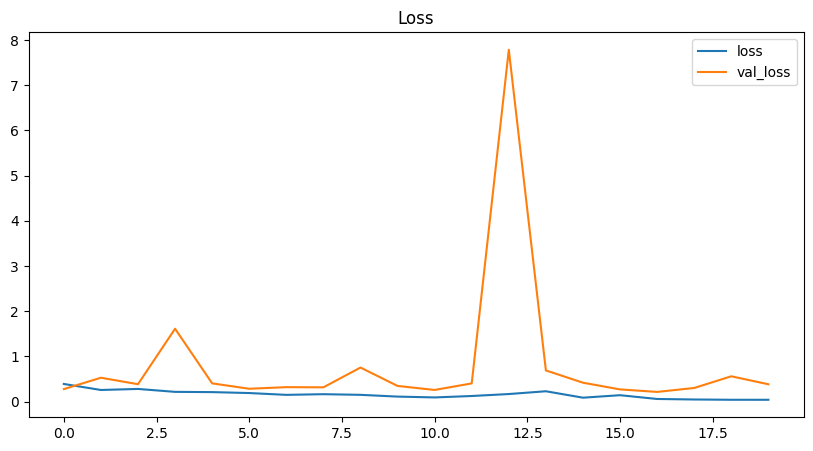

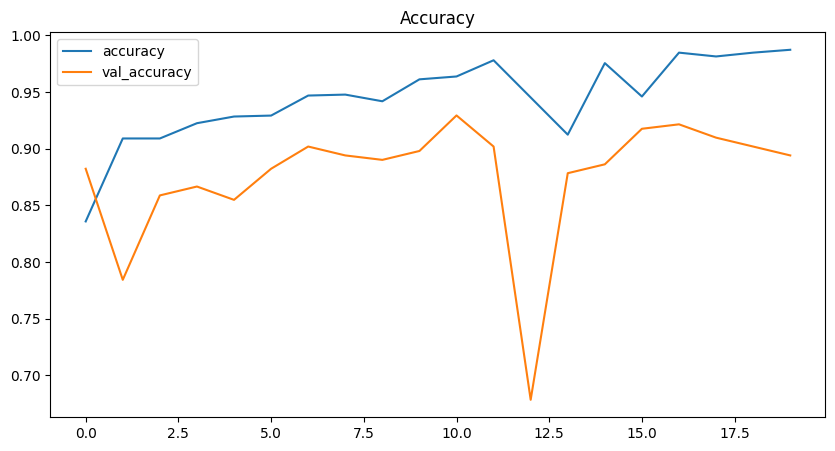

Precision: 0.8510638475418091
Recall: 0.9599999785423279
Accuracy: 0.8980392217636108


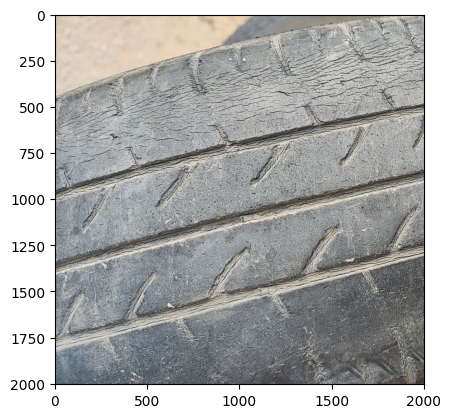

Predicted class is defective tyre


In [1]:
import os
import cv2
import imghdr
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import torchmetrics

# GPU setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing
#data_dir = r"C:\Users\dubey\OneDrive\Desktop\Dait (Summer Intership )\Tyre dataset"
data_dir = r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\Tyre dataset"

image_exts = ['jpeg', 'jpg', 'bmp', 'png']

# Validate and clean data
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# Custom Dataset
class TyreDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = os.listdir(data_dir)
        self.image_paths = []
        self.labels = []

        for idx, image_class in enumerate(self.classes):
            image_class_path = os.path.join(data_dir, image_class)
            for image in os.listdir(image_class_path):
                image_path = os.path.join(image_class_path, image)
                self.image_paths.append(image_path)
                self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create dataset
dataset = TyreDataset(data_dir, transform=transform)

# Split dataset
train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=0.3, stratify=dataset.labels)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, stratify=[dataset.labels[i] for i in test_idx])

train_data = Subset(dataset, train_idx)
val_data = Subset(dataset, val_idx)
test_data = Subset(dataset, test_idx)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

# Define ResNet-152-based classifier
class TyreClassifierResNet152(nn.Module):
    def __init__(self):
        super(TyreClassifierResNet152, self).__init__()
        self.model = models.resnet152(pretrained=True)

        # Replace the fully connected layer
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Instantiate and prepare
model = TyreClassifierResNet152().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float()

            optimizer.zero_grad()
            outputs = model(images).squeeze()

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = outputs.round()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        val_loss = 0
        val_correct = 0
        val_total = 0
        model.eval()
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float()

                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                preds = outputs.round()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        history['loss'].append(train_loss/len(train_loader))
        history['val_loss'].append(val_loss/len(val_loader))
        history['accuracy'].append(correct/total)
        history['val_accuracy'].append(val_correct/val_total)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}, Accuracy: {correct/total}, Val Accuracy: {val_correct/val_total}')

    return history

# Train the model
history = train_model(model, train_loader, val_loader, criterion, optimizer)

# Plotting the results
plt.figure(figsize=(10,5))
plt.title("Loss")
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Accuracy")
plt.plot(history['accuracy'], label='accuracy')
plt.plot(history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

# Evaluation
model.eval()
#precision = torchmetrics.Precision().to(device)
#recall = torchmetrics.Recall().to(device)
#accuracy = torchmetrics.Accuracy().to(device)
precision = torchmetrics.classification.Precision(task="binary").to(device)
recall = torchmetrics.classification.Recall(task="binary").to(device)
accuracy = torchmetrics.classification.Accuracy(task="binary").to(device)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float()
        outputs = model(images).squeeze()

        preds = outputs.round()
        #precision = torchmetrics.Precision(task="binary").to(device)
        #recall = torchmetrics.Recall(task="binary").to(device)
        #accuracy = torchmetrics.Accuracy(task="binary").to(device)

        precision.update(preds, labels)
        recall.update(preds, labels)
        accuracy.update(preds, labels)

print(f'Precision: {precision.compute()}')
print(f'Recall: {recall.compute()}')
print(f'Accuracy: {accuracy.compute()}')

# Prediction example
def predict_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        yhat = model(img).squeeze().item()

    if yhat > 0.5:
        print(f'Predicted class is good tyre')
    else:
        print(f'Predicted class is defective tyre')
#test_image_path = r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\trainging image for tyre\Defective (1).jpg"

#predict_image(r"C:\Users\dubey\OneDrive\Desktop\Dait (Summer Intership )\Good\good (1).jpg")
predict_image(r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\trainging image for tyre\Defective (1).jpg")

In [ ]:
## DenseNet-201-based classifier

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import torchmetrics

# GPU setup
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(device)

import torch

# Check if CUDA (GPU support) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# If using CUDA, print GPU name
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("Running on CPU")


Using device: cuda
GPU Name: NVIDIA GeForce RTX 3050 Laptop GPU


In [ ]:
import os
import cv2
import imghdr
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import torchmetrics

# GPU setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing
#data_dir = r"C:\Users\dubey\OneDrive\Desktop\Dait (Summer Intership )\Tyre dataset"
data_dir = r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\Tyre dataset"

image_exts = ['jpeg', 'jpg', 'bmp', 'png']

# Validate and clean data
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# Custom Dataset
class TyreDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = os.listdir(data_dir)
        self.image_paths = []
        self.labels = []

        for idx, image_class in enumerate(self.classes):
            image_class_path = os.path.join(data_dir, image_class)
            for image in os.listdir(image_class_path):
                image_path = os.path.join(image_class_path, image)
                self.image_paths.append(image_path)
                self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label
        
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(300),               # shorter side = 300 (preserves aspect ratio)
    transforms.CenterCrop(300),           # crops to 300x300
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create dataset
dataset = TyreDataset(data_dir, transform=transform)

# Split dataset
train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=0.3, stratify=dataset.labels)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, stratify=[dataset.labels[i] for i in test_idx])

train_data = Subset(dataset, train_idx)
val_data = Subset(dataset, val_idx)
test_data = Subset(dataset, test_idx)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

# Define DenseNet-201-based classifier
class TyreClassifierDenseNet201(nn.Module):
    def __init__(self):
        super(TyreClassifierDenseNet201, self).__init__()
        self.model = models.densenet201(pretrained=True)
        
        # Replace the classifier head
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Instantiate and prepare
model = TyreClassifierDenseNet201().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float()

            optimizer.zero_grad()
            outputs = model(images).squeeze()

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = outputs.round()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        val_loss = 0
        val_correct = 0
        val_total = 0
        model.eval()
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float()

                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                preds = outputs.round()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        history['loss'].append(train_loss/len(train_loader))
        history['val_loss'].append(val_loss/len(val_loader))
        history['accuracy'].append(correct/total)
        history['val_accuracy'].append(val_correct/val_total)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}, Accuracy: {correct/total}, Val Accuracy: {val_correct/val_total}')

    return history

# Train the model
history = train_model(model, train_loader, val_loader, criterion, optimizer)

# Plotting the results
plt.figure(figsize=(10,5))
plt.title("Loss")
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Accuracy")
plt.plot(history['accuracy'], label='accuracy')
plt.plot(history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

# Evaluation
model.eval()
#precision = torchmetrics.Precision().to(device)
#recall = torchmetrics.Recall().to(device)
#accuracy = torchmetrics.Accuracy().to(device)
precision = torchmetrics.classification.Precision(task="binary").to(device)
recall = torchmetrics.classification.Recall(task="binary").to(device)
accuracy = torchmetrics.classification.Accuracy(task="binary").to(device)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float()
        outputs = model(images).squeeze()

        preds = outputs.round()
        #precision = torchmetrics.Precision(task="binary").to(device)
        #recall = torchmetrics.Recall(task="binary").to(device)
        #accuracy = torchmetrics.Accuracy(task="binary").to(device)

        precision.update(preds, labels)
        recall.update(preds, labels)
        accuracy.update(preds, labels)

print(f'Precision: {precision.compute()}')
print(f'Recall: {recall.compute()}')
print(f'Accuracy: {accuracy.compute()}')

# Prediction example
def predict_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        yhat = model(img).squeeze().item()

    if yhat > 0.5:
        print(f'Predicted class is good tyre')
    else:
        print(f'Predicted class is defective tyre')
#test_image_path = r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\trainging image for tyre\Defective (1).jpg"

#predict_image(r"C:\Users\dubey\OneDrive\Desktop\Dait (Summer Intership )\Good\good (1).jpg")
predict_image(r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\trainging image for tyre\Defective (1).jpg")

In [ ]:
## EfficientNet-B3 Based Tyre Classifier

In [ ]:
import os
import cv2
import imghdr
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import torchmetrics

# GPU setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing
#data_dir = r"C:\Users\dubey\OneDrive\Desktop\Dait (Summer Intership )\Tyre dataset"
data_dir = r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\Tyre dataset"

image_exts = ['jpeg', 'jpg', 'bmp', 'png']

# Validate and clean data
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# Custom Dataset
class TyreDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = os.listdir(data_dir)
        self.image_paths = []
        self.labels = []

        for idx, image_class in enumerate(self.classes):
            image_class_path = os.path.join(data_dir, image_class)
            for image in os.listdir(image_class_path):
                image_path = os.path.join(image_class_path, image)
                self.image_paths.append(image_path)
                self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(300),               # shorter side = 300 (preserves aspect ratio)
    transforms.CenterCrop(300),           # crops to 300x300
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create dataset
dataset = TyreDataset(data_dir, transform=transform)

# Split dataset
train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=0.3, stratify=dataset.labels)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, stratify=[dataset.labels[i] for i in test_idx])

train_data = Subset(dataset, train_idx)
val_data = Subset(dataset, val_idx)
test_data = Subset(dataset, test_idx)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

# Define EfficientNet-B3-based classifier
class TyreClassifierEfficientNetB3(nn.Module):
    def __init__(self):
        super(TyreClassifierEfficientNetB3, self).__init__()
        self.model = models.efficientnet_b3(pretrained=True)

        # Replace the classifier head
        in_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Instantiate and prepare
model = TyreClassifierEfficientNetB3().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float()

            optimizer.zero_grad()
            outputs = model(images).squeeze()

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = outputs.round()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        val_loss = 0
        val_correct = 0
        val_total = 0
        model.eval()
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float()

                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                preds = outputs.round()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        history['loss'].append(train_loss/len(train_loader))
        history['val_loss'].append(val_loss/len(val_loader))
        history['accuracy'].append(correct/total)
        history['val_accuracy'].append(val_correct/val_total)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}, Accuracy: {correct/total}, Val Accuracy: {val_correct/val_total}')

    return history

# Train the model
history = train_model(model, train_loader, val_loader, criterion, optimizer)

# Plotting the results
plt.figure(figsize=(10,5))
plt.title("Loss")
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Accuracy")
plt.plot(history['accuracy'], label='accuracy')
plt.plot(history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

# Evaluation
model.eval()
#precision = torchmetrics.Precision().to(device)
#recall = torchmetrics.Recall().to(device)
#accuracy = torchmetrics.Accuracy().to(device)
precision = torchmetrics.classification.Precision(task="binary").to(device)
recall = torchmetrics.classification.Recall(task="binary").to(device)
accuracy = torchmetrics.classification.Accuracy(task="binary").to(device)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float()
        outputs = model(images).squeeze()

        preds = outputs.round()
        #precision = torchmetrics.Precision(task="binary").to(device)
        #recall = torchmetrics.Recall(task="binary").to(device)
        #accuracy = torchmetrics.Accuracy(task="binary").to(device)

        precision.update(preds, labels)
        recall.update(preds, labels)
        accuracy.update(preds, labels)

print(f'Precision: {precision.compute()}')
print(f'Recall: {recall.compute()}')
print(f'Accuracy: {accuracy.compute()}')

# Prediction example
def predict_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

    transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(300),               # shorter side = 300 (preserves aspect ratio)
    transforms.CenterCrop(300),           # crops to 300x300
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
    img = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        yhat = model(img).squeeze().item()

    if yhat > 0.5:
        print(f'Predicted class is good tyre')
    else:
        print(f'Predicted class is defective tyre')
#test_image_path = r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\trainging image for tyre\Defective (1).jpg"

#predict_image(r"C:\Users\dubey\OneDrive\Desktop\Dait (Summer Intership )\Good\good (1).jpg")
predict_image(r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\trainging image for tyre\Defective (1).jpg")

C:\Users\dubey\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\dubey\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Loss: 0.22718322625089632, Val Loss: 0.14726602472364902, Accuracy: 0.914983164983165, Val Accuracy: 0.9411764705882353
Epoch 2/20, Loss: 0.11364806105235689, Val Loss: 0.10325448028743267, Accuracy: 0.9595959595959596, Val Accuracy: 0.9607843137254902
Epoch 3/20, Loss: 0.10282937363770447, Val Loss: 0.1878553181886673, Accuracy: 0.9730639730639731, Val Accuracy: 0.9372549019607843
Epoch 4/20, Loss: 0.0849622958401022, Val Loss: 0.09106172508836607, Accuracy: 0.9747474747474747, Val Accuracy: 0.9725490196078431


In [ ]:
## InceptionResNetV2-based classifier

model.safetensors:   0%|          | 0.00/224M [00:00<?, ?B/s]

Error while downloading from https://cdn-lfs.hf.co/repos/3c/df/3cdf0e9041d4094d8c9c4f687f92413d990d9cf01530c39da2784480a77870b2/dbea26b13a5fc8351919fed6a94222c0577ce324b2765fd081a798f837ca9d72?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1744369270&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NDM2OTI3MH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy8zYy9kZi8zY2RmMGU5MDQxZDQwOTRkOGM5YzRmNjg3ZjkyNDEzZDk5MGQ5Y2YwMTUzMGMzOWRhMjc4NDQ4MGE3Nzg3MGIyL2RiZWEyNmIxM2E1ZmM4MzUxOTE5ZmVkNmE5NDIyMmMwNTc3Y2UzMjRiMjc2NWZkMDgxYTc5OGY4MzdjYTlkNzI%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qIn1dfQ__&Signature=SqvxVw2VIi-NPOka027Zwve%7E3ryT8C-WOLQCaHQ8I7Y3HbIpqcRVNMPVXDz-3Pq1vbTs358iIwDSk0ApIKJTFl8XvtMM7HIrBHmNUrltwodEDN%7Eh9d6egztmR1eCjRW80-ELeXxAzmyVzuraauVuXW-YExH31rV10M8%7E45xLo6Z3GFAIAZ15Lx9x09p%7EmI5pyVDHQQt5QObtdoTqA6LTt%7Ee6PwqX4ky2UFguwRHyKzf%7EcQJ9IFHQj3uqI7yii4j

model.safetensors:   0%|          | 0.00/224M [00:00<?, ?B/s]

C:\Users\dubey\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\dubey\.cache\huggingface\hub\models--timm--inception_resnet_v2.tf_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Epoch 1/20, Loss: 0.27667780769498723, Val Loss: 10.217097282409668, Accuracy: 0.8914141414141414, Val Accuracy: 0.796078431372549
Epoch 2/20, Loss: 0.122331050714772, Val Loss: 2.0559118818491697, Accuracy: 0.9553872053872053, Val Accuracy: 0.8509803921568627
Epoch 3/20, Loss: 0.17743269297735473, Val Loss: 0.9939855150878429, Accuracy: 0.9562289562289562, Val Accuracy: 0.8352941176470589
Epoch 4/20, Loss: 0.16756788866692468, Val Loss: 0.6571059972047806, Accuracy: 0.9410774410774411, Val Accuracy: 0.9333333333333333
Epoch 5/20, Loss: 0.11050956636226099, Val Loss: 0.19728890853002667, Accuracy: 0.9646464646464646, Val Accuracy: 0.9411764705882353
Epoch 6/20, Loss: 0.06901241329768182, Val Loss: 0.3965311152860522, Accuracy: 0.9806397306397306, Val Accuracy: 0.9254901960784314
Epoch 7/20, Loss: 0.21004199123892345, Val Loss: 0.5734855337068439, Accuracy: 0.9393939393939394, Val Accuracy: 0.9529411764705882
Epoch 8/20, Loss: 0.1219637037107819, Val Loss: 0.33221039548516273, Accuracy:

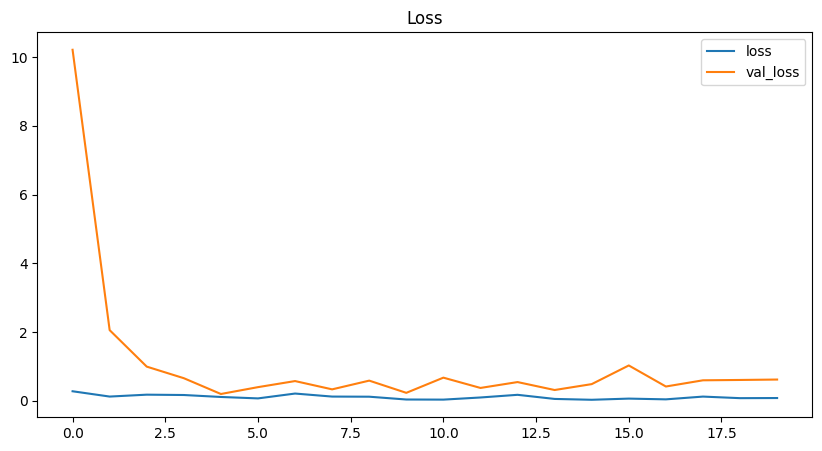

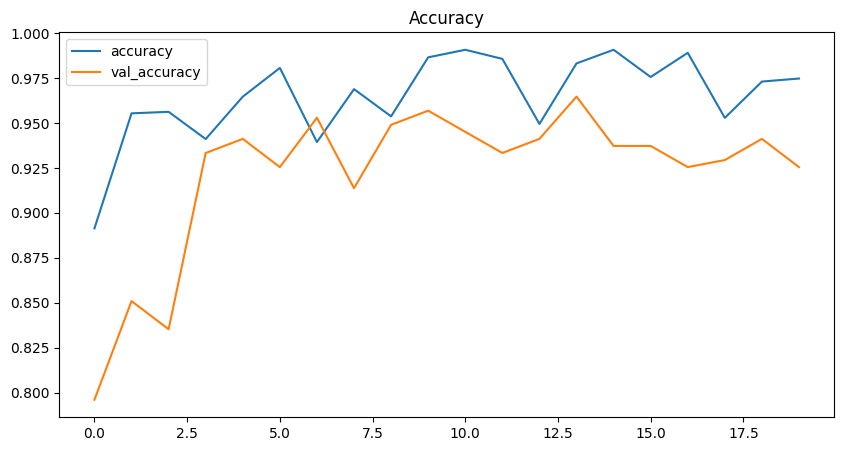

Precision: 0.9359999895095825
Recall: 0.9359999895095825
Accuracy: 0.9372549057006836


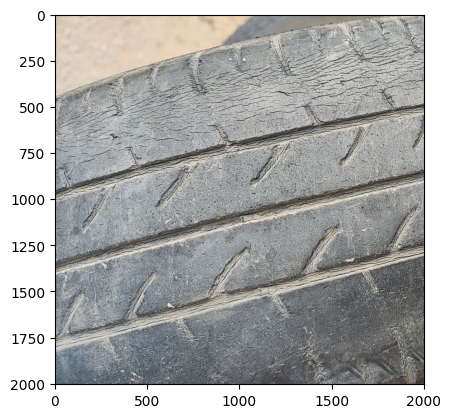

Predicted class is defective tyre


In [4]:
import os
import cv2
import imghdr
import timm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import torchmetrics

# GPU setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing
#data_dir = r"C:\Users\dubey\OneDrive\Desktop\Dait (Summer Intership )\Tyre dataset"
data_dir = r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\Tyre dataset"

image_exts = ['jpeg', 'jpg', 'bmp', 'png']

# Validate and clean data
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# Custom Dataset
class TyreDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = os.listdir(data_dir)
        self.image_paths = []
        self.labels = []

        for idx, image_class in enumerate(self.classes):
            image_class_path = os.path.join(data_dir, image_class)
            for image in os.listdir(image_class_path):
                image_path = os.path.join(image_class_path, image)
                self.image_paths.append(image_path)
                self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create dataset
dataset = TyreDataset(data_dir, transform=transform)

# Split dataset
train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=0.3, stratify=dataset.labels)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, stratify=[dataset.labels[i] for i in test_idx])

train_data = Subset(dataset, train_idx)
val_data = Subset(dataset, val_idx)
test_data = Subset(dataset, test_idx)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

#import timm  # pip install timm

# Define InceptionResNetV2-based classifier
class TyreClassifierInceptionResNetV2(nn.Module):
    def __init__(self):
        super(TyreClassifierInceptionResNetV2, self).__init__()
        # Load pretrained model from timm
        self.model = timm.create_model('inception_resnet_v2', pretrained=True)

        # Modify the classifier head
        in_features = self.model.classif.in_features
        self.model.classif = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Instantiate and prepare
model = TyreClassifierInceptionResNetV2().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float()

            optimizer.zero_grad()
            outputs = model(images).squeeze()

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = outputs.round()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        val_loss = 0
        val_correct = 0
        val_total = 0
        model.eval()
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float()

                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                preds = outputs.round()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        history['loss'].append(train_loss/len(train_loader))
        history['val_loss'].append(val_loss/len(val_loader))
        history['accuracy'].append(correct/total)
        history['val_accuracy'].append(val_correct/val_total)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}, Accuracy: {correct/total}, Val Accuracy: {val_correct/val_total}')

    return history

# Train the model
history = train_model(model, train_loader, val_loader, criterion, optimizer)

# Plotting the results
plt.figure(figsize=(10,5))
plt.title("Loss")
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Accuracy")
plt.plot(history['accuracy'], label='accuracy')
plt.plot(history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

# Evaluation
model.eval()
#precision = torchmetrics.Precision().to(device)
#recall = torchmetrics.Recall().to(device)
#accuracy = torchmetrics.Accuracy().to(device)
precision = torchmetrics.classification.Precision(task="binary").to(device)
recall = torchmetrics.classification.Recall(task="binary").to(device)
accuracy = torchmetrics.classification.Accuracy(task="binary").to(device)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float()
        outputs = model(images).squeeze()

        preds = outputs.round()
        #precision = torchmetrics.Precision(task="binary").to(device)
        #recall = torchmetrics.Recall(task="binary").to(device)
        #accuracy = torchmetrics.Accuracy(task="binary").to(device)

        precision.update(preds, labels)
        recall.update(preds, labels)
        accuracy.update(preds, labels)

print(f'Precision: {precision.compute()}')
print(f'Recall: {recall.compute()}')
print(f'Accuracy: {accuracy.compute()}')

# Prediction example
def predict_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        yhat = model(img).squeeze().item()

    if yhat > 0.5:
        print(f'Predicted class is good tyre')
    else:
        print(f'Predicted class is defective tyre')
#test_image_path = r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\trainging image for tyre\Defective (1).jpg"

#predict_image(r"C:\Users\dubey\OneDrive\Desktop\Dait (Summer Intership )\Good\good (1).jpg")
predict_image(r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\trainging image for tyre\Defective (1).jpg")

In [ ]:
## MobileNetV2-based classifier

C:\Users\dubey\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\dubey\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\dubey/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|█████████████████████████████████████████████████████████████████████████████| 13.6M/13.6M [00:05<00:00, 2.54MB/s]


Epoch 1/20, Loss: 0.3041594414726684, Val Loss: 0.21306587010622025, Accuracy: 0.872895622895623, Val Accuracy: 0.9176470588235294
Epoch 2/20, Loss: 0.20637434760206624, Val Loss: 0.16319835558533669, Accuracy: 0.9267676767676768, Val Accuracy: 0.9372549019607843
Epoch 3/20, Loss: 0.13697199675401575, Val Loss: 0.26729785464704037, Accuracy: 0.9528619528619529, Val Accuracy: 0.9215686274509803
Epoch 4/20, Loss: 0.1084601067459995, Val Loss: 0.19625737995374948, Accuracy: 0.9629629629629629, Val Accuracy: 0.9490196078431372
Epoch 5/20, Loss: 0.09200274952577035, Val Loss: 0.12311763723846525, Accuracy: 0.9646464646464646, Val Accuracy: 0.9647058823529412
Epoch 6/20, Loss: 0.08740105661318491, Val Loss: 0.19197838427498937, Accuracy: 0.9671717171717171, Val Accuracy: 0.9372549019607843
Epoch 7/20, Loss: 0.13257312215864658, Val Loss: 0.2994585132692009, Accuracy: 0.9436026936026936, Val Accuracy: 0.9098039215686274
Epoch 8/20, Loss: 0.1474535661308389, Val Loss: 0.26150123309344053, Accu

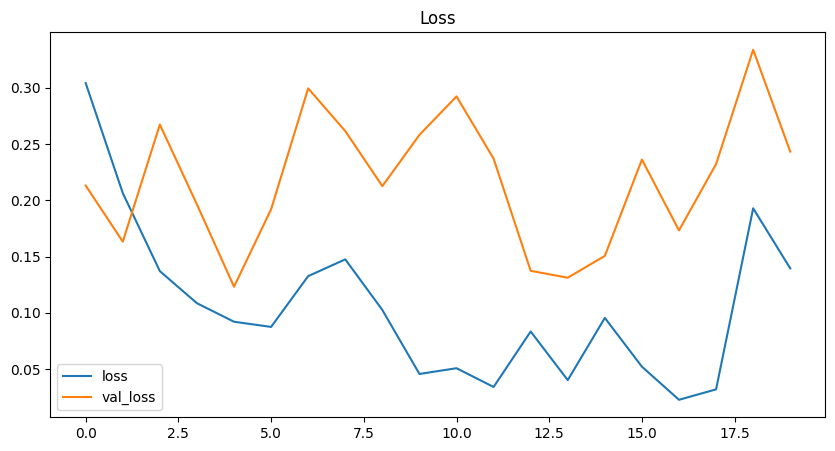

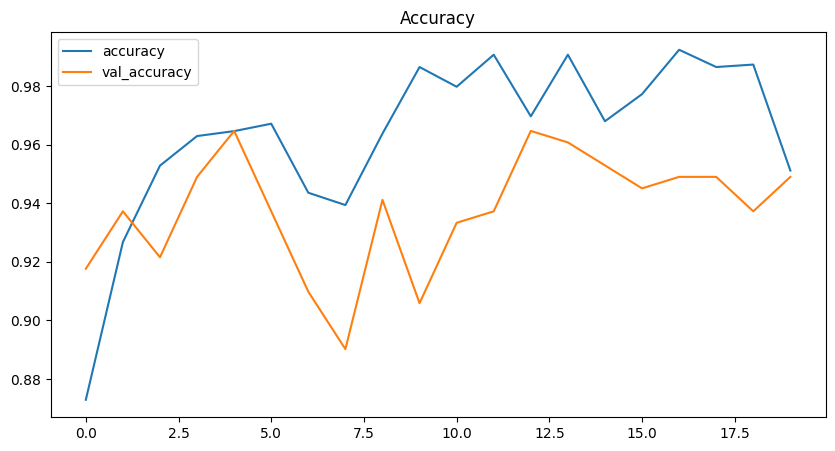

Precision: 0.9734513163566589
Recall: 0.8799999952316284
Accuracy: 0.929411768913269


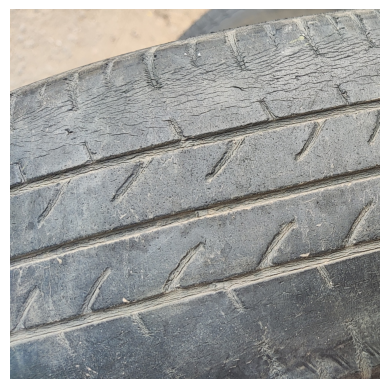

Predicted class is defective tyre


In [3]:
import os
import cv2
import imghdr
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import torchmetrics

# GPU setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing
data_dir = r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\Tyre dataset"
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

# Validate and clean data
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print(f'Image not in ext list {image_path}')
                os.remove(image_path)
        except Exception as e:
            print(f'Issue with image {image_path}')

# Custom Dataset
class TyreDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = os.listdir(data_dir)
        self.image_paths = []
        self.labels = []

        for idx, image_class in enumerate(self.classes):
            image_class_path = os.path.join(data_dir, image_class)
            for image in os.listdir(image_class_path):
                image_path = os.path.join(image_class_path, image)
                self.image_paths.append(image_path)
                self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Transform for all processing
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create and split dataset
dataset = TyreDataset(data_dir, transform=transform)
train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=0.3, stratify=dataset.labels)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, stratify=[dataset.labels[i] for i in test_idx])

train_data = Subset(dataset, train_idx)
val_data = Subset(dataset, val_idx)
test_data = Subset(dataset, test_idx)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

# Define model
class TyreClassifierMobileNetV2(nn.Module):
    def __init__(self):
        super(TyreClassifierMobileNetV2, self).__init__()
        self.model = models.mobilenet_v2(pretrained=True)
        in_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = TyreClassifierMobileNetV2().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = outputs.round()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        val_loss = 0
        val_correct = 0
        val_total = 0
        model.eval()

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float()
                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                preds = outputs.round()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        history['loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss / len(val_loader))
        history['accuracy'].append(correct / total)
        history['val_accuracy'].append(val_correct / val_total)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}, Accuracy: {correct/total}, Val Accuracy: {val_correct/val_total}')

    return history

# Train
history = train_model(model, train_loader, val_loader, criterion, optimizer)

# Plot metrics
plt.figure(figsize=(10,5))
plt.title("Loss")
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Accuracy")
plt.plot(history['accuracy'], label='accuracy')
plt.plot(history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

# Evaluate
precision = torchmetrics.classification.Precision(task="binary").to(device)
recall = torchmetrics.classification.Recall(task="binary").to(device)
accuracy = torchmetrics.classification.Accuracy(task="binary").to(device)

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float()
        outputs = model(images).squeeze()
        preds = outputs.round()
        precision.update(preds, labels)
        recall.update(preds, labels)
        accuracy.update(preds, labels)

print(f'Precision: {precision.compute()}')
print(f'Recall: {recall.compute()}')
print(f'Accuracy: {accuracy.compute()}')

# Prediction function
def predict_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    img = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        yhat = model(img).squeeze().item()

    if yhat > 0.5:
        print('Predicted class is good tyre')
    else:
        print('Predicted class is defective tyre')

# Predict a sample
predict_image(r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\trainging image for tyre\Defective (1).jpg")


In [ ]:
## ✅ Tyre Classifier using VGG16

C:\Users\dubey\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\dubey\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Loss: 45.6822, Val Loss: 49.0675, Accuracy: 0.5269, Val Accuracy: 0.5098
Epoch 2/20, Loss: 49.0132, Val Loss: 48.9919, Accuracy: 0.5101, Val Accuracy: 0.5098
Epoch 3/20, Loss: 47.8618, Val Loss: 49.0297, Accuracy: 0.5101, Val Accuracy: 0.5098
Epoch 4/20, Loss: 48.4375, Val Loss: 49.0297, Accuracy: 0.5101, Val Accuracy: 0.5098
Epoch 5/20, Loss: 48.4375, Val Loss: 49.0423, Accuracy: 0.5101, Val Accuracy: 0.5098
Epoch 6/20, Loss: 48.4375, Val Loss: 48.9793, Accuracy: 0.5101, Val Accuracy: 0.5098
Epoch 7/20, Loss: 49.0132, Val Loss: 49.0927, Accuracy: 0.5101, Val Accuracy: 0.5098
Epoch 8/20, Loss: 49.0132, Val Loss: 49.0171, Accuracy: 0.5101, Val Accuracy: 0.5098
Epoch 9/20, Loss: 49.5888, Val Loss: 49.0675, Accuracy: 0.5101, Val Accuracy: 0.5098
Epoch 10/20, Loss: 49.0132, Val Loss: 49.0297, Accuracy: 0.5101, Val Accuracy: 0.5098
Epoch 11/20, Loss: 49.0132, Val Loss: 48.9541, Accuracy: 0.5101, Val Accuracy: 0.5098
Epoch 12/20, Loss: 49.5888, Val Loss: 49.0297, Accuracy: 0.5101

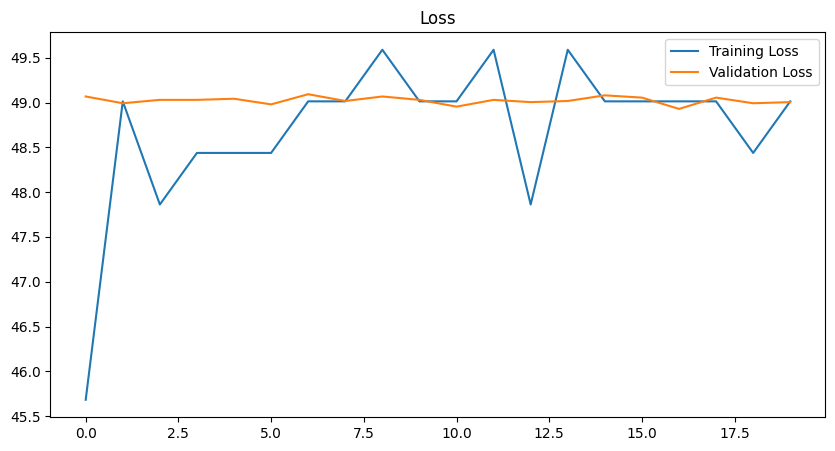

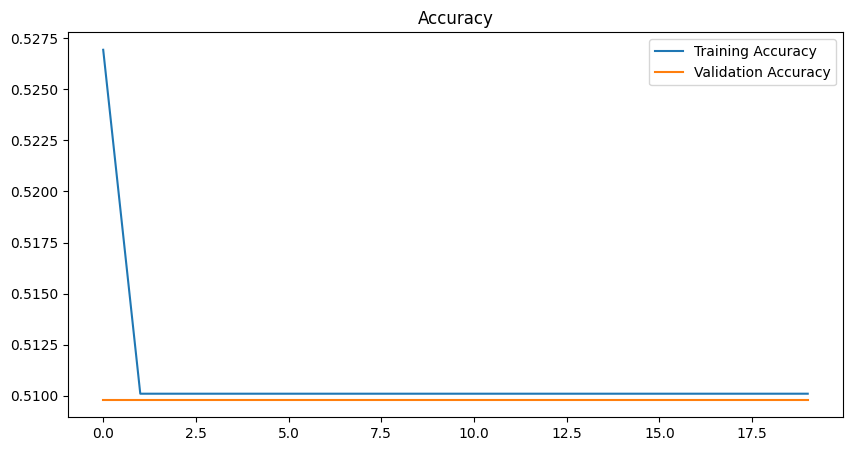

Precision: 0.0000
Recall: 0.0000
Accuracy: 0.5098


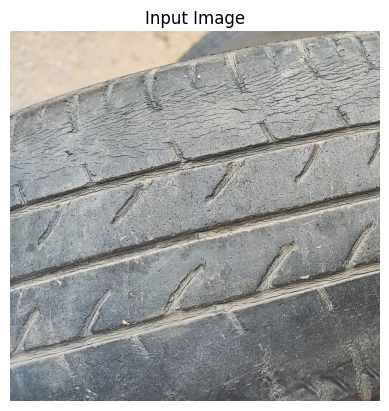

Predicted class: ❌ Defective Tyre (Confidence: 0.00)


In [1]:
import os
import cv2
import imghdr
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import torchmetrics

# GPU setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data directory
data_dir = r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\Tyre dataset"

image_exts = ['jpeg', 'jpg', 'bmp', 'png']

# Validate and clean data
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

# Custom Dataset
class TyreDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = os.listdir(data_dir)
        self.image_paths = []
        self.labels = []

        for idx, image_class in enumerate(self.classes):
            image_class_path = os.path.join(data_dir, image_class)
            for image in os.listdir(image_class_path):
                image_path = os.path.join(image_class_path, image)
                self.image_paths.append(image_path)
                self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Image transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset and split
dataset = TyreDataset(data_dir, transform=transform)
train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=0.3, stratify=dataset.labels)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, stratify=[dataset.labels[i] for i in test_idx])

train_data = Subset(dataset, train_idx)
val_data = Subset(dataset, val_idx)
test_data = Subset(dataset, test_idx)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

# VGG16-based classifier
class TyreClassifierVGG16(nn.Module):
    def __init__(self):
        super(TyreClassifierVGG16, self).__init__()
        self.model = models.vgg16(pretrained=True)

        # Modify the classifier head
        self.model.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Instantiate model
model = TyreClassifierVGG16().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(images).squeeze()

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = outputs.round()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float()
                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.round()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        # Log metrics
        history['loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss / len(val_loader))
        history['accuracy'].append(correct / total)
        history['val_accuracy'].append(val_correct / val_total)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss / len(train_loader):.4f}, '
              f'Val Loss: {val_loss / len(val_loader):.4f}, Accuracy: {correct / total:.4f}, '
              f'Val Accuracy: {val_correct / val_total:.4f}')

    return history

# Train the model
history = train_model(model, train_loader, val_loader, criterion, optimizer)

# Plot training results
plt.figure(figsize=(10, 5))
plt.title("Loss")
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.title("Accuracy")
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Evaluate on test set
model.eval()
precision = torchmetrics.classification.Precision(task="binary").to(device)
recall = torchmetrics.classification.Recall(task="binary").to(device)
accuracy = torchmetrics.classification.Accuracy(task="binary").to(device)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float()
        outputs = model(images).squeeze()
        preds = outputs.round()
        precision.update(preds, labels)
        recall.update(preds, labels)
        accuracy.update(preds, labels)

print(f'Precision: {precision.compute():.4f}')
print(f'Recall: {recall.compute():.4f}')
print(f'Accuracy: {accuracy.compute():.4f}')

# Predict on single image
def predict_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis("off")
    plt.show()

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    img_tensor = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        yhat = model(img_tensor).squeeze().item()

    if yhat > 0.5:
        print(f'Predicted class: ✅ Good Tyre (Confidence: {yhat:.2f})')
    else:
        print(f'Predicted class: ❌ Defective Tyre (Confidence: {yhat:.2f})')

# Predict sample
predict_image(r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\trainging image for tyre\Defective (1).jpg")


In [ ]:
## ✅ Tyre Classifier using Xception (via timm)

C:\Users\dubey\AppData\Local\Programs\Python\Python310\lib\site-packages\timm\models\_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Epoch 1/20, Loss: 0.3196, Val Loss: 1.0482, Accuracy: 0.9015, Val Accuracy: 0.8667
Epoch 2/20, Loss: 0.2170, Val Loss: 0.2637, Accuracy: 0.9436, Val Accuracy: 0.9137
Epoch 3/20, Loss: 0.1145, Val Loss: 0.6453, Accuracy: 0.9621, Val Accuracy: 0.9059
Epoch 4/20, Loss: 0.0993, Val Loss: 0.2044, Accuracy: 0.9621, Val Accuracy: 0.9569
Epoch 5/20, Loss: 0.0578, Val Loss: 0.6928, Accuracy: 0.9840, Val Accuracy: 0.9216
Epoch 6/20, Loss: 0.0551, Val Loss: 0.1440, Accuracy: 0.9865, Val Accuracy: 0.9529
Epoch 7/20, Loss: 0.0316, Val Loss: 0.1175, Accuracy: 0.9907, Val Accuracy: 0.9725
Epoch 8/20, Loss: 0.0390, Val Loss: 0.1689, Accuracy: 0.9874, Val Accuracy: 0.9608
Epoch 9/20, Loss: 0.0233, Val Loss: 0.1334, Accuracy: 0.9916, Val Accuracy: 0.9608
Epoch 10/20, Loss: 0.0372, Val Loss: 0.0779, Accuracy: 0.9865, Val Accuracy: 0.9804
Epoch 11/20, Loss: 0.0203, Val Loss: 0.1219, Accuracy: 0.9958, Val Accuracy: 0.9647
Epoch 12/20, Loss: 0.3056, Val Loss: 0.1315, Accuracy: 0.9865, Val Accuracy: 0.9569
E

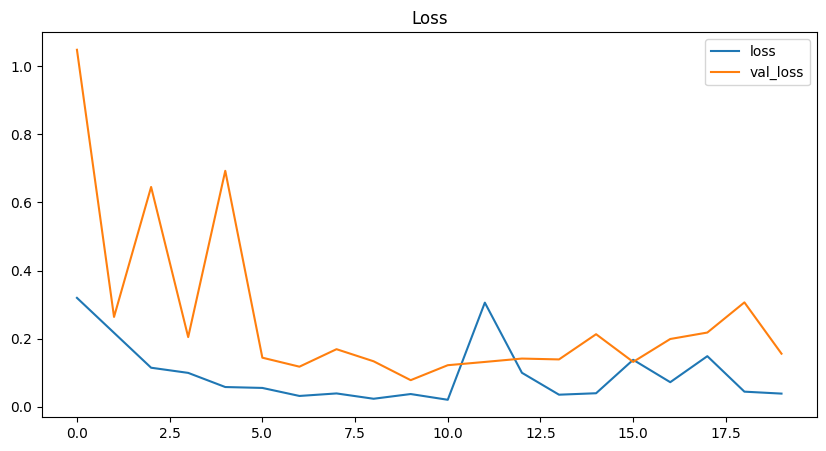

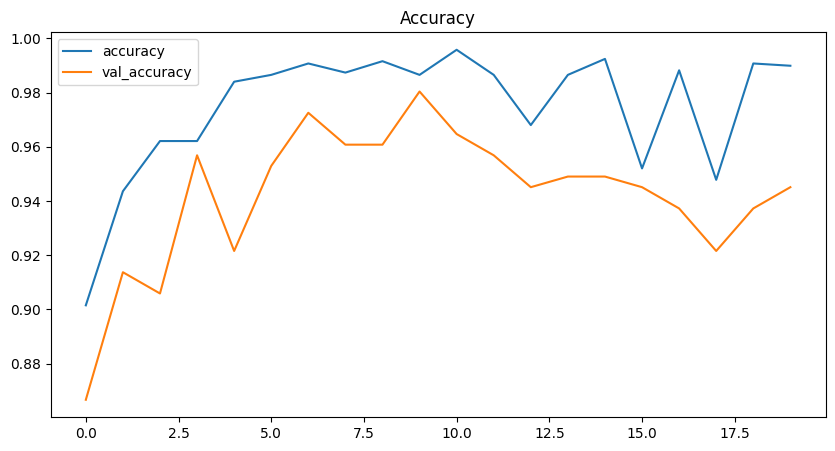

Precision: 0.9297
Recall: 0.9520
Accuracy: 0.9412


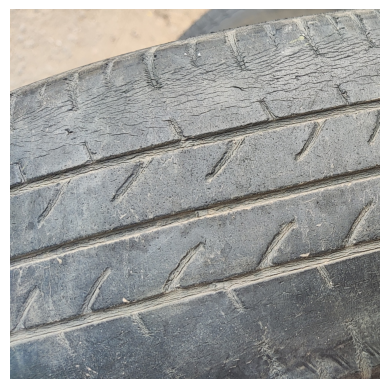

Predicted class is: Defective Tyre


In [1]:
import os
import cv2
import imghdr
import timm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torchmetrics

# GPU setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data directory
data_dir = r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\Tyre dataset"
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

# Validate and clean data
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

# Custom Dataset
class TyreDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = os.listdir(data_dir)
        self.image_paths = []
        self.labels = []

        for idx, image_class in enumerate(self.classes):
            image_class_path = os.path.join(data_dir, image_class)
            for image in os.listdir(image_class_path):
                image_path = os.path.join(image_class_path, image)
                self.image_paths.append(image_path)
                self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Image transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(320),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create dataset and split
dataset = TyreDataset(data_dir, transform=transform)
train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=0.3, stratify=dataset.labels)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, stratify=[dataset.labels[i] for i in test_idx])

train_data = Subset(dataset, train_idx)
val_data = Subset(dataset, val_idx)
test_data = Subset(dataset, test_idx)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

# Define model
class TyreClassifierXception(nn.Module):
    def __init__(self):
        super(TyreClassifierXception, self).__init__()
        self.model = timm.create_model('xception', pretrained=True, num_classes=1)
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Instantiate
model = TyreClassifierXception().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = outputs.round()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        val_loss = 0
        val_correct = 0
        val_total = 0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.round()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        history['loss'].append(train_loss/len(train_loader))
        history['val_loss'].append(val_loss/len(val_loader))
        history['accuracy'].append(correct/total)
        history['val_accuracy'].append(val_correct/val_total)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/total:.4f}, Val Accuracy: {val_correct/val_total:.4f}')
    
    return history

# Train
history = train_model(model, train_loader, val_loader, criterion, optimizer)

# Plot
plt.figure(figsize=(10,5))
plt.title("Loss")
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Accuracy")
plt.plot(history['accuracy'], label='accuracy')
plt.plot(history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

# Evaluation metrics
precision = torchmetrics.classification.Precision(task="binary").to(device)
recall = torchmetrics.classification.Recall(task="binary").to(device)
accuracy = torchmetrics.classification.Accuracy(task="binary").to(device)

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(images)
        preds = outputs.round()

        precision.update(preds, labels)
        recall.update(preds, labels)
        accuracy.update(preds, labels)

print(f'Precision: {precision.compute():.4f}')
print(f'Recall: {recall.compute():.4f}')
print(f'Accuracy: {accuracy.compute():.4f}')

# Prediction
def predict_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    img = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        yhat = model(img).item()

    if yhat > 0.5:
        print(f'Predicted class is: Good Tyre')
    else:
        print(f'Predicted class is: Defective Tyre')

# Test example
predict_image(r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\trainging image for tyre\Defective (1).jpg")


In [ ]:
## ✅ TyreClassifier – CNN from Scratch

Epoch 1/20, Loss: 0.620528225836001, Val Loss: 0.6532959751784801, Accuracy: 0.7508417508417509, Val Accuracy: 0.7607843137254902
Epoch 2/20, Loss: 0.5892169412813688, Val Loss: 0.6043568216264248, Accuracy: 0.8114478114478114, Val Accuracy: 0.8196078431372549
Epoch 3/20, Loss: 0.5772495959934435, Val Loss: 0.5709782689809799, Accuracy: 0.8459595959595959, Val Accuracy: 0.8470588235294118
Epoch 4/20, Loss: 0.5738711906106848, Val Loss: 0.6167754381895065, Accuracy: 0.8484848484848485, Val Accuracy: 0.7803921568627451
Epoch 5/20, Loss: 0.5758507879156816, Val Loss: 0.603581078350544, Accuracy: 0.8409090909090909, Val Accuracy: 0.8274509803921568
Epoch 6/20, Loss: 0.5692781915790156, Val Loss: 0.5969470590353012, Accuracy: 0.8661616161616161, Val Accuracy: 0.796078431372549
Epoch 7/20, Loss: 0.5902853051298543, Val Loss: 0.59151541441679, Accuracy: 0.8097643097643098, Val Accuracy: 0.7764705882352941
Epoch 8/20, Loss: 0.5778342359944394, Val Loss: 0.5780597515404224, Accuracy: 0.84680134

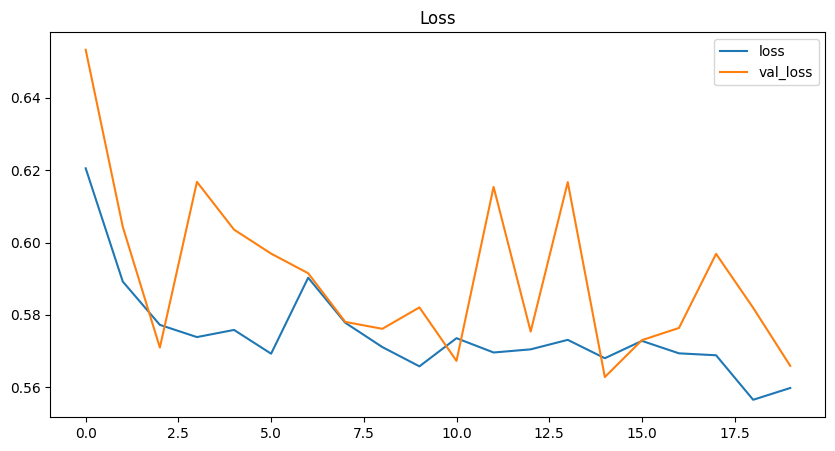

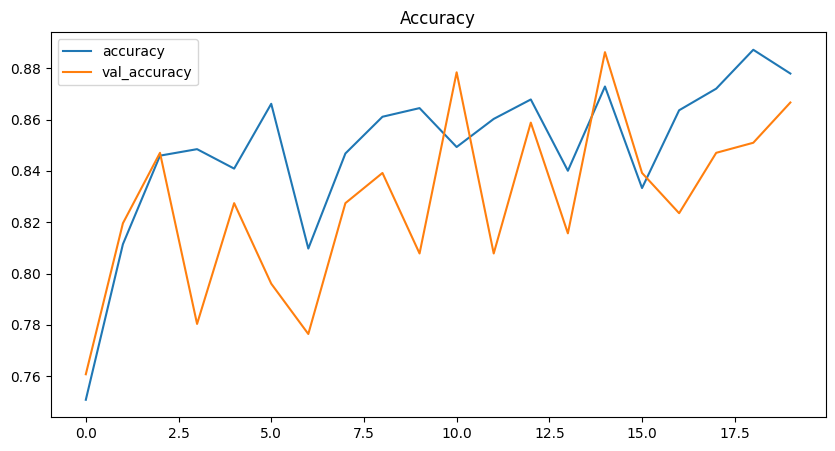

Precision: 0.9230769276618958
Recall: 0.8640000224113464
Accuracy: 0.8980392217636108


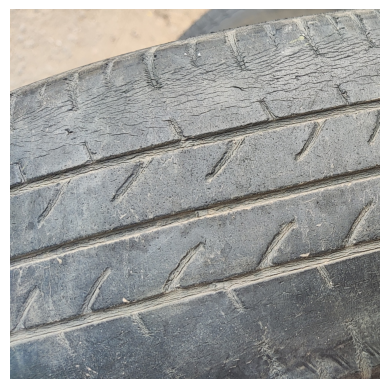

Predicted class is defective tyre


In [2]:
import os
import cv2
import imghdr
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torchmetrics

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data directory
data_dir = r"C:\\Users\\dubey\\OneDrive\\Desktop\\Final Sem Project\\Data set\\Tyre dataset"

# Valid image extensions
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

# Data validation and cleanup
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

# Custom Dataset class
class TyreDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = os.listdir(data_dir)
        self.image_paths = []
        self.labels = []

        for idx, image_class in enumerate(self.classes):
            image_class_path = os.path.join(data_dir, image_class)
            for image in os.listdir(image_class_path):
                image_path = os.path.join(image_class_path, image)
                self.image_paths.append(image_path)
                self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Image transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create dataset and dataloaders
dataset = TyreDataset(data_dir, transform=transform)
train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=0.3, stratify=dataset.labels)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, stratify=[dataset.labels[i] for i in test_idx])

train_data = Subset(dataset, train_idx)
val_data = Subset(dataset, val_idx)
test_data = Subset(dataset, test_idx)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# CNN Model Definition
class TyreClassifierCNN(nn.Module):
    def __init__(self):
        super(TyreClassifierCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Model instantiation and setup
model = TyreClassifierCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float()

            optimizer.zero_grad()
            outputs = model(images).squeeze()
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = outputs.round()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        val_loss = 0
        val_correct = 0
        val_total = 0
        model.eval()
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float()

                outputs = model(images).squeeze()
                outputs = torch.sigmoid(outputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                preds = outputs.round()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        history['loss'].append(train_loss/len(train_loader))
        history['val_loss'].append(val_loss/len(val_loader))
        history['accuracy'].append(correct/total)
        history['val_accuracy'].append(val_correct/val_total)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}, Accuracy: {correct/total}, Val Accuracy: {val_correct/val_total}')

    return history

# Train the model
history = train_model(model, train_loader, val_loader, criterion, optimizer)

# Plot training history
plt.figure(figsize=(10,5))
plt.title("Loss")
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Accuracy")
plt.plot(history['accuracy'], label='accuracy')
plt.plot(history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

# Evaluation with torchmetrics
precision = torchmetrics.classification.Precision(task="binary").to(device)
recall = torchmetrics.classification.Recall(task="binary").to(device)
accuracy = torchmetrics.classification.Accuracy(task="binary").to(device)

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float()
        outputs = torch.sigmoid(model(images).squeeze())
        preds = outputs.round()

        precision.update(preds, labels)
        recall.update(preds, labels)
        accuracy.update(preds, labels)

print(f'Precision: {precision.compute()}')
print(f'Recall: {recall.compute()}')
print(f'Accuracy: {accuracy.compute()}')

# Predict a single image
def predict_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    img = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        yhat = torch.sigmoid(model(img).squeeze()).item()

    if yhat > 0.5:
        print(f'Predicted class is good tyre')
    else:
        print(f'Predicted class is defective tyre')

# Example usage:
# predict_image(r"C:\\Users\\dubey\\OneDrive\\Desktop\\Final Sem Project\\Data set\\trainging image for tyre\\Defective (1).jpg")
predict_image(r"C:\Users\dubey\OneDrive\Desktop\Final Sem Project\Data set\trainging image for tyre\Defective (1).jpg")